In [38]:
from tqdm import tqdm
from pit30m import LogReader
import glob
import numpy as np
from uuid import UUID

from pit30m.data.partitions import PreProcessPartition
from pit30m.camera import CamName

%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
# with open("../pit30m/all_logs.txt", "r") as f:
#     logs = f.readlines()
#     logs = [x.strip() for x in logs]

logs = []
for f in glob.glob("/home/julieta/pit30m_partitions/utm_poses_dense/to_hide/*"):
    logs.append(f.split("/")[-1][:-4])

In [17]:
log_readers = {}
for logid in logs[:20]:
    log_readers[logid] = LogReader(f"s3://pit30m/{logid}/", partitions=[PreProcessPartition.VALID])

  0%|          | 0/20 [00:00<?, ?it/s]

Total included: 0


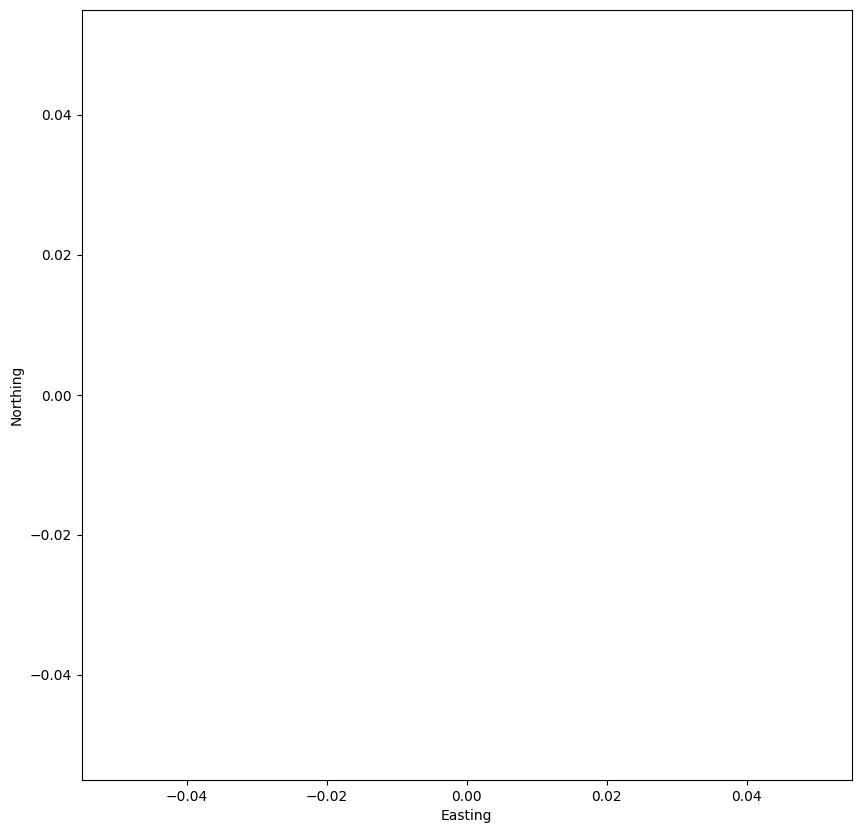

In [28]:
figsz = 20 // 2
fig = plt.figure(figsize=(figsz, figsz), dpi=100, facecolor='w', edgecolor='k')

included = 0
for log_id, lr in tqdm(log_readers.items()):
    
    hidden_in_log = 0
    # index = lr.get_cam_geo_index(CamName.MIDDLE_FRONT_WIDE)
    index = lr.map_relative_poses_dense
    break
    # index = lr.utm_poses_dense
    print(index.dtype.names)
    
    x = index["utm_x"]
    y = index["utm_y"]
    sc = plt.scatter(x, y, s=0.5, alpha=0.5)
    break
    
    included += len(x)
    
    # percent_hidden = 100 * hidden_in_log / len(utm)
    # if percent_hidden > 90: 
    #     print(f"{log_id} has {hidden_in_log:_} poses to hide ({percent_hidden:.2f}%)")

plt.axis("square")
plt.xlabel("Easting")
plt.ylabel("Northing")
print(f"Total included: {included:_}")

In [41]:
sorted([UUID(bytes=x.ljust(16, b"\x00")) for x in np.unique(index["submap_id"])])

[UUID('00000000-0000-0000-0000-000000000000'),
 UUID('00a53038-3072-4115-f458-02769036233f'),
 UUID('082c2a5a-7516-4f9e-fce0-6ab6eb3e0965'),
 UUID('0d864017-a690-4255-c225-551e3c48705f'),
 UUID('105b3cdb-0ce3-4aec-c667-8b5ecfac2874'),
 UUID('12e48274-21e0-4340-d3fa-101b21a1baab'),
 UUID('17b09d4c-2514-43c8-f3e3-8133a4ebc62e'),
 UUID('17e4e37a-17c5-42ff-faed-c646cc9db2c9'),
 UUID('20d6e773-1562-43a2-ed4d-ea344f57c41d'),
 UUID('23a758df-eff6-4416-f68d-777972106245'),
 UUID('25ca0525-a64d-48cc-cfc4-af3f06570621'),
 UUID('260b1e82-67dd-4343-f4dd-d59dd7d54ac7'),
 UUID('2e9a8e56-c301-4ddb-ee8c-057b8da6f002'),
 UUID('2eee3d5b-e2a7-4a9c-e115-6f2864eb7ff9'),
 UUID('3e91088e-ad38-4dc8-e170-f0145f26963a'),
 UUID('44fdefd6-7445-4137-cfdc-8589cfb5e1a9'),
 UUID('4feef829-f17b-454c-c2c5-b5d87ab49272'),
 UUID('57c6cfcd-4f25-43a9-f16d-08a4f59ca6d1'),
 UUID('57e0018e-10b1-422e-fb97-64f93fcbb4ef'),
 UUID('5b823b3d-2ca8-4d12-ea84-3da66dd3d78a'),
 UUID('5d4ef0ed-fa18-411d-e8f3-36c7b3807747'),
 UUID('6010ba

In [ ]:
from typing import Iterable
from pathlib import Path
from joblib import Parallel, delayed
import pickle
from numpy.lib import recfunctions as rfn

def get_utm_poses_with_metadata(lr):
    pose_time, pose_valid, pose_xy = lr.utm_poses_dense
    time = rfn.unstructured_to_structured(pose_time[:, np.newaxis], names=["utm_time"])
    # assert np.all(np.diff(time["utm_time"]) >= 0), "Pose times are not sorted"
    valid = rfn.unstructured_to_structured(pose_valid[:, np.newaxis], names=["utm_valid"])
    # assert len(valid) == len(pose_valid)
    xys = rfn.unstructured_to_structured(pose_xy, names=["utm_x", "utm_y"])
    # assert len(xys) == len(pose_xy)
    sensor_poses = rfn.merge_arrays([time, valid, xys], flatten=True)

    return lr.log_id, sensor_poses

def get_utm_dense_poses(
    logs: Iterable[UUID],
    logreader_path: Path = Path("/mnt/data/pit30m/pose-backup-2023-04-18/"),
    pool: Parallel = None,
    pickled: bool = None,
):
    """Multiple ways to get dense poses
    Args:
        logs: list of log ids whose dense poses we want to load
        logreader_path: Path where to load log readers from
        pool: pool of parallel workers to load the poses
        pickled: whether to load from a pre-dumped pickled file on disk
    """

    log_readers = [LogReader(str(logreader_path / f"{log}")) for log in logs]

    if pickled:
        # If loading from pickle, ignore everything and just load from disk
        with open("/home/julieta/pickles/utm_dense_poses.pkl", "rb") as handle:
            sensor_poses = pickle.load(handle)

        # The pickle has everything -- filter for the ones that were asked for
        sensor_poses = {log_id: sensor_pose for (log_id, sensor_pose) in sensor_poses.items() if log_id in logs}
    else:
        if pool:
            res = pool(delayed(get_utm_poses_with_metadata)(lr) for lr in log_readers)
            sensor_poses = {log_id: index for (log_id, index) in res}
        else:
            sensor_poses = {
                log_id: get_utm_poses_with_metadata(lr)[1]
                for (log_id, lr) in tqdm(
                    zip(logs, log_readers), total=len(logs), desc="Getting dense poses sequentially from disk"
                )
            }

    log_readers = {log_id: lr for (log_id, lr) in zip(logs, log_readers)}
    return sensor_poses, log_readers, pool
